To train this agent, click *Runtime* and press *Run all*. Make sure you've enabled a free Tesla T4 GPU!
<div class="align-center">
<a href="https://github.com/openpipe/art"><img src="https://github.com/openpipe/art/raw/main/assets/ART_pill.png" height="50"></a>
<a href="https://discord.com/invite/dnseNZuQ"><img src="https://github.com/openpipe/art/raw/main/assets/Discord_pill.png" height="50"></a>
<a href="https://openpipe.ai/blog/art-trainer-a-new-rl-trainer-for-agents"><img src="https://github.com/openpipe/art/raw/main/assets/Launch_pill.png" height="50"></a>

Questions? Join the Discord and ask away! For feature requests or to leave a star, visit our [Github](https://github.com/openpipe/art).
</div>

<a href="https://art.openpipe.ai/"><img src="https://github.com/openpipe/art/raw/main/assets/Header_separator.png" height="5"></a>

This notebook shows how to train a Qwen 2.5 3B model to play Codenames. It will demonstrate how to set up a multi-turn agent, how to train it, and how to evaluate it.

Completions will be logged to OpenPipe, and metrics will be logged to Weights & Biases.


You will learn how to construct an [agentic environment](#Environment), how to define a [rollout](#Rollout), and how to run a [training loop](#Loop).

In [ ]:
!pip install "numpy<2.0.0"

### WARNING:
If you are running in Google Colab and installing numpy does not say "Requirement already satisfied: numpy<2.0.0" then click "Runtime" and "Restart Session."

In [ ]:
# make sure we're using numpy 1.*.*
import numpy as np

if (np.__version__).startswith("1."):
    print("Numpy version is 1.*.*, you're good to go!")
else:
    raise ValueError("Please restart your runtime using the above instructions!")

Numpy version is 1.*.*, you're good to go!


### Environment Variables

Later on in the notebook, we'll be creating a model that can automatically logs metrics to Weights & Biases. In order to do so, you'll need to provide your Weights & Biases API key as an environment variable.

You can also optionally initiate an OpenPipe client to report completions to a [dashboard](https://app.openpipe.ai) to get a feel for what the completions your model is generating look like, and how they change over time. Logging to OpenPipe is free, but is not required for training!

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()
# from google.colab import userdata

# Optional
WANDB_API_KEY = os.getenv("WANDB_API_KEY") or ""
if WANDB_API_KEY:
    os.environ["WANDB_API_KEY"] = WANDB_API_KEY
# elif userdata.get("WANDB_API_KEY"):
#     os.environ["WANDB_API_KEY"] = userdata.get("WANDB_API_KEY")

# Optional
OPENPIPE_API_KEY = os.getenv("OPENPIPE_API_KEY") or ""
if OPENPIPE_API_KEY:
    os.environ["OPENPIPE_API_KEY"] = OPENPIPE_API_KEY
# elif userdata.get("OPENPIPE_API_KEY"):
#     os.environ["OPENPIPE_API_KEY"] = userdata.get("OPENPIPE_API_KEY")

### Installation

In [ ]:
%%capture
!uv pip install openpipe-art openpipe --prerelease allow --no-cache-dir

### Agentic Environment
<a name="Environment"></a>

ART allows your agent to learn by interacting with its environment. In this example, we'll create an environment in which the agent can play Codenames.

Feel free to read as much or as little of this section's code as you'd like. The important thing to understand is that we're defining the rules of this agent's environment. In many cases, this will already be defined by the task you're trying to solve, but if you need to define a custom environment, this is how you do it.

In [ ]:
# Download the 400 original codenames words and a dictionary to ensure that the clue is not outside of this dictionary
!curl -o codenames_words.txt https://raw.githubusercontent.com/saum7800/codenames-public-data/refs/heads/main/codenames_words.txt
!curl -o dictionary.txt https://raw.githubusercontent.com/saum7800/codenames-public-data/refs/heads/main/dictionary.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2481  100  2481    0     0   6941      0 --:--:-- --:--:-- --:--:--  6949
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4749k  100 4749k    0     0  5151k      0 --:--:-- --:--:-- --:--:-- 5150k


In [3]:
# Basic imports to get us running
# ───────────────────────────────  Imports  ────────────────────────────────
import asyncio
import copy
import logging
import random
import re
import time
import uuid
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple

from openai import AsyncOpenAI
from tqdm.asyncio import tqdm_asyncio

import art
from openpipe.client import AsyncOpenPipe

/workspace/codenames-rl/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# ───────────────────────────────  Config  ──────────────────────────────
WORDS_FILE = "codenames_words.txt"
DICTIONARY_FILE = "dictionary.txt"
NUM_ITERS = 140
NUM_GAMES_PER_ITER = 10
NUM_ROLLOUTS_PER_GAME = 20
MODEL_NAME = "codenames_model_op_3"
BASE_MODEL_NAME = "Qwen/Qwen2.5-3B-Instruct"
VAL_BENCHMARK_MODEL = "gpt-4.1-nano"
NUM_VALIDATION_GAMES = 50
LEARNING_RATE = 5e-6
BETA = 0.0
DEBUG = False

# — reward constants —
# The following is the weightage for different kinds of outcomes from a game, to determine the reward
MARGIN_REWARD_DICT = {
    "turn_limit": -100,
    "error": -100,
    "assassin": -30,
    "num_words_multiplier": 10,
    "margin_multiplier": 1,
}

In [6]:
# ────────────────────────  1. Utility helpers  ────────────────────────────
def load_words(path: str, return_lower: bool = True) -> List[str]:
    """
    Read newline‑separated words from *path*.

    Args:
        path: text file containing one word per line.
        return_lower: convert to lowercase before returning.

    Returns:
        List[str]: non‑empty, stripped words.
    """
    with open(path, "r", encoding="utf-8") as f:
        words = [line.strip() for line in f if line.strip()]
    return [w.lower() for w in words] if return_lower else words


async def call_llm(
    client: AsyncOpenAI,
    model: str,
    messages: List[Dict[str, str]],
    temperature: float = 0.7,
    max_tokens: int = 500,
    num_retries: int = 3,
):
    """
    Minimal, retry‑aware wrapper around `chat.completions.create`.
    """
    for attempt in range(num_retries):
        try:
            resp = await client.chat.completions.create(
                model=model,
                messages=messages,
                temperature=temperature,
                max_tokens=max_tokens,
                logprobs=True,
                store=False,
            )
            if not resp:
                raise RuntimeError("empty response")
            return resp
        except Exception as e:
            print(f"LLM error ({attempt+1}/{num_retries}): {e}")
            await asyncio.sleep(1)
    raise RuntimeError("LLM call failed after retries")


# ───────────────────────  2. Core game classes  ───────────────────────────
class Card:
    """
    One word on the Codenames board.
    """
    def __init__(self, word: str, color: str):
        self.word = word
        self.color = color  # blue | red | neutral | assassin
        self.revealed = False

    def __repr__(self) -> str:
        return f"{self.word}{'(X)' if self.revealed else ''}:{self.color}"


class GameState:
    """
    Full mutable game state with an event log.
    """
    def __init__(
        self,
        cards: List[Card],
        starting_team: str = "blue",
        game_id: int = 0,
        all_words: List[str] | None = None,
    ):
        self.cards = cards
        self.current_team = starting_team
        self.words_left = {
            "blue": sum(1 for c in cards if c.color == "blue"),
            "red":  sum(1 for c in cards if c.color == "red"),
        }
        self.starting_team = starting_team
        self.game_id = game_id
        self.turn_count = 0

        self.last_event_indices: Dict[str, int] = {
            "blue_spymaster": -1,
            "blue_operative": -1,
            "red_spymaster": -1,
            "red_operative": -1,
            "game_engine": -1,
        }
        self.game_events: List[Dict[str, str]] = []

        self.game_ended_in_error: Dict[str, str] | None = None
        self.game_ended_in_assassin = False
        self.game_ended_in_turn_limit = False

        self.all_words = all_words or load_words(DICTIONARY_FILE)

    # ───────── event log helpers ─────────
    def log_event(self, role_key: str, description: str) -> None:
        self.game_events.append({role_key: description})
        self.last_event_indices[role_key] = len(self.game_events) - 1
        if DEBUG:
          print(f"{role_key}: {description}")

    def format_events_for_player(self, role_key: str) -> str:
        last_seen = self.last_event_indices.get(role_key, -1)
        new_events = self.game_events[last_seen + 1 :]
        if not new_events:
            return ""
        lines = ["--- events since your last turn ---"]
        for ev in new_events:
            for rk, desc in ev.items():
                lines.append(f"{rk}: {desc}")
        lines.append("----------------------------------")
        return "\n".join(lines)

    # ───────── board helpers ─────────
    def reveal_card(self, card: Card) -> str | None:
        if card.revealed:
            return None
        card.revealed = True
        if card.color in ("blue", "red"):
            self.words_left[card.color] -= 1
        return card.color

    def get_unrevealed_cards(self) -> List[Card]:
        return [c for c in self.cards if not c.revealed]

    def get_revealed_cards(self) -> List[Card]:
        return [c for c in self.cards if c.revealed]

    # ───────── rules / win conditions ─────────
    def check_end_game(self) -> Tuple[str | None, str | None]:
        # assassin?
        if any(c for c in self.cards if c.color == "assassin" and c.revealed):
            loser = self.current_team
            winner = "red" if loser == "blue" else "blue"
            self.game_ended_in_assassin = True
            return winner, f"{loser} revealed the assassin"
        # all words guessed?
        if self.words_left["blue"] == 0:
            return "blue", "Blue found all their words"
        if self.words_left["red"] == 0:
            return "red", "Red found all their words"
        return None, None

    def switch_turn(self) -> None:
        self.current_team = "red" if self.current_team == "blue" else "blue"

    def enforce_clue_rules(self, clue_word: str) -> bool:
        # single token
        if len(clue_word.split()) > 1:
            return False
        # letters / hyphens only
        if re.search(r"[^A-Za-z\-]", clue_word):
            return False
        # cannot be an unrevealed board word
        if clue_word.lower() in {c.word.lower() for c in self.get_unrevealed_cards()}:
            return False
        # must be in dictionary
        if clue_word.lower() not in self.all_words:
            return False
        return True

def create_operative_feedback(max_guesses, guesses_taken, guess, color, outcome):
    operative_feedback = ""
    if outcome.startswith("correct"):
        operative_feedback = f"Your guess '{guess}' was correct! It belongs to your team ({color})."
        if guesses_taken >= max_guesses:
            operative_feedback += f" Max guesses reached ({max_guesses}), ending turn."
        else:
            operative_feedback += " Either provide your next guess from the unrevealed cards on the board, or say end_turn."
    elif outcome == "neutral":
        operative_feedback = f"Your guess '{guess}' was neutral. Your turn ends here."
    elif outcome.startswith("other_team"):
        operative_feedback = f"Your guess '{guess}' belongs to the other team ({color}). Your turn ends here."
    return operative_feedback

# ───────────────────────  3. Game orchestration  ──────────────────────────
def create_game(
    word_dictionary_path: str,
    num_words: int = 25,
    blue_count: int = 9,
    red_count: int = 8,
    assassin_count: int = 1,
    neutral_count: int = 7,
    starting_team: str = "blue",
    game_id: int = 0,
) -> GameState:
    all_words = load_words(word_dictionary_path, return_lower=True)
    random.shuffle(all_words)
    words = all_words[:num_words]

    colors = (
        ["blue"] * blue_count
        + ["red"] * red_count
        + ["assassin"] * assassin_count
        + ["neutral"] * neutral_count
    )
    random.shuffle(colors)

    cards = [Card(w, c) for w, c in zip(words, colors)]
    return GameState(cards, starting_team, game_id)

In [7]:
# ───────────────────────  LLM player classes  ──────────────────────────
SPYMASTER_SYSTEM_PROMPT = """You are a SPYMASTER in a game of Codenames.
You are on a team (blue or red).
You see which words belong to blue, red, neutral, and assassin.
Your objective:
- Give a ONE-WORD CLUE and a NUMBER, to guide your operative to guess your team's words.
- Avoid giving a clue that makes your operative guess the assassin word, or else you lose immediately.
- If the operative guesses a neutral or enemy word, the word is revealed and your turn ends, but the game continues.
Strict format rules:
- You must propose exactly one single-word clue
- The clue must not be a word on the board
- Your output must be in the format: clue_word, number (e.g. "space, 2")
If you ever deviate from that exact output format, you lose.
Please follow these instructions exactly."""

SPYMASTER_USER_PROMPT = """Your turn. You are the {team} spymaster.
Here is the current board (from your perspective), showing:
  - which words are unrevealed (and their colors),
  - which words are revealed (and their colors).
You need to give a single-word clue and a number of words you want your operative to guess.

{board}

Please provide your ONE-WORD clue and a number, in the format: clue_word, number"""

OPERATIVE_SYSTEM_PROMPT = """You are an OPERATIVE in a game of Codenames.
- Your spymaster gives you a ONE-WORD CLUE and a NUMBER.
- You must guess words from the unrevealed board that match that clue.
- You propose exactly ONE guess at a time, or say "end_turn" to stop guessing.
- If you guess an enemy word or neutral word, your turn ends.
- If you guess the assassin word, you immediately lose.
- The clue's NUMBER is how many words the spymaster believes are related, but you can guess up to NUMBER + 1 (or fewer).
Format rules:
- Output must be either a single unrevealed word present on the board or "end_turn".
- If you deviate from that, you lose."""

OPERATIVE_USER_PROMPT = """Your turn. You are the {team} operative.
Your spymaster's clue is: "{clue}" (number: {num}).
Below is the board from your perspective:
  - Which words are still unrevealed (without color info),
  - Which words are revealed (with color).

{board}

Remember: Output exactly one guess word or 'end_turn'."""


class LLMSpymaster:
    def __init__(
        self,
        team: str,
        model: str,
        client: AsyncOpenAI,
        temperature: float = 0.7,
        max_tokens: int = 20,
    ):
        self.team = team
        self.model = model
        self.client = client
        self.temperature = temperature
        self.max_tokens = max_tokens
        self.conversation: List[Dict[str, str]] = [
            {"role": "system", "content": SPYMASTER_SYSTEM_PROMPT}
        ]
        self.conversation_choices: List[dict] = []

    def _board_summary(self, game_state):
        unrevealed_cards = game_state.get_unrevealed_cards()
        revealed_cards = game_state.get_revealed_cards()

        lines = []
        lines.append(f"Number of words left for blue: {game_state.words_left['blue']}")
        lines.append(f"Number of words left for red: {game_state.words_left['red']}")
        lines.append("UNREVEALED WORDS (and their colors):")
        # Group cards by color
        # Group cards by color and add them in a specific order
        for color in [self.team, "red" if self.team == "blue" else "blue", "neutral", "assassin"]:
            for c in [c for c in unrevealed_cards if c.color == color]:
                lines.append(f"  {c.word} => {c.color}")
        lines.append("REVEALED WORDS (and their colors):")
        for c in revealed_cards:
            lines.append(f"  {c.word} => {c.color} (revealed)")

        return "\n".join(lines)

    def _parse_clue(self, text: str, gs: GameState) -> Tuple[str, int]:
        try:
            cw, num = (s.strip() for s in text.split(",", 1))
            num = int(num)
        except Exception:
            return "invalid", -1
        if not gs.enforce_clue_rules(cw):
            return "invalid", -1
        return cw, num

    async def get_clue(
        self, gs: GameState, game_events: str, enforce_rules: bool = True
    ) -> Tuple[str, int]:
        if game_events:
            self.conversation.append({"role": "user", "content": game_events})

        prompt = SPYMASTER_USER_PROMPT.format(
            team=self.team, board=self._board_summary(gs)
        )
        self.conversation.append({"role": "user", "content": prompt})

        resp = await call_llm(
            self.client,
            self.model,
            self.conversation,
            self.temperature,
            self.max_tokens,
        )
        self.conversation_choices.append(resp.choices[0])
        text = resp.choices[0].message.content.strip()  # type: ignore
        self.conversation.append({"role": "assistant", "content": text})

        return self._parse_clue(text, gs)


class LLMOperative:
    def __init__(
        self,
        team: str,
        model: str,
        client: AsyncOpenAI,
        temperature: float = 0.7,
        max_tokens: int = 20,
    ):
        self.team = team
        self.model = model
        self.client = client
        self.temperature = temperature
        self.max_tokens = max_tokens
        self.conversation: List[Dict[str, str]] = [
            {"role": "system", "content": OPERATIVE_SYSTEM_PROMPT}
        ]
        self.conversation_choices: List[dict] = []
        self.new_turn = True

    def _board_summary(self, game_state: GameState):
        """
        Build a summary from the operative's perspective:
          - unrevealed words (no color info)
          - revealed words (with color)
        """
        unrevealed = game_state.get_unrevealed_cards()
        revealed = game_state.get_revealed_cards()

        lines = []
        lines.append(f"Number of words left for blue: {game_state.words_left['blue']}")
        lines.append(f"Number of words left for red: {game_state.words_left['red']}")
        lines.append("UNREVEALED WORDS (no color info):")
        for c in unrevealed:
            lines.append(f"  {c.word}")
        lines.append("REVEALED WORDS (with color):")
        for c in revealed:
            lines.append(f"  {c.word}:{c.color}")
        return "\n".join(lines)

    async def guess_word(
        self,
        gs: GameState,
        clue_word: str,
        clue_number: int,
        game_events: str,
    ) -> str:
        if self.new_turn:
            self.new_turn = False
            if game_events:
                self.conversation.append({"role": "user", "content": game_events})
            prompt = OPERATIVE_USER_PROMPT.format(
                team=self.team,
                clue=clue_word,
                num=clue_number,
                board=self._board_summary(gs),
            )
            self.conversation.append({"role": "user", "content": prompt})

        resp = await call_llm(
            self.client,
            self.model,
            self.conversation,
            self.temperature,
            self.max_tokens,
        )
        self.conversation_choices.append(resp.choices[0])
        guess = resp.choices[0].message.content.strip()  # type: ignore
        self.conversation.append({"role": "assistant", "content": guess})
        return guess

    def start_new_turn(self):
        self.new_turn = True

    def add_guess_outcome(self, outcome: str):
        self.conversation.append({"role": "user", "content": outcome})


In [8]:
# ───────────────────────  Gameplay  ──────────────────────────
async def run_game(
    gs: GameState,
    blue_spy: LLMSpymaster,
    blue_op: LLMOperative,
    red_spy: LLMSpymaster,
    red_op: LLMOperative,
    enforce_clue_rules: bool = True,
) -> Tuple[str, str]:
    """
    Main loop – returns (winner, reason)
    """
    while True:
        # turn limit
        if gs.turn_count >= 50:
            gs.game_ended_in_turn_limit = True
            return "No winner", "Turn limit reached"

        gs.turn_count += 1

        # victory check
        winner, reason = gs.check_end_game()
        if winner:
            gs.log_event("game_engine", f"GAME OVER: {reason}")
            return winner, reason

        # who’s up?
        team = gs.current_team
        spy = blue_spy if team == "blue" else red_spy
        op  = blue_op  if team == "blue" else red_op
        spy_key = f"{team}_spymaster"
        op_key = f"{team}_operative"

        # ── Spymaster turn ──
        spy_events = gs.format_events_for_player(spy_key)
        clue_word, clue_num = await spy.get_clue(gs, spy_events, enforce_clue_rules)

        if clue_word == "invalid" or clue_num < 0:
            other = "red" if team == "blue" else "blue"
            reason = f"{team} gave invalid clue"
            gs.log_event("game_engine", f"GAME OVER: {other} wins – {reason}")
            gs.game_ended_in_error = {"team": team, "role": "spymaster"}
            return other, reason

        gs.log_event(spy_key, f"clue '{clue_word}', {clue_num}")

        # ── Operative guesses ──
        max_guesses = clue_num + 1
        guesses = 0
        op.start_new_turn()

        while guesses < max_guesses:
            # check win before guess
            winner, reason = gs.check_end_game()
            if winner:
                gs.log_event("game_engine", f"GAME OVER: {reason}")
                return winner, reason

            op_events = gs.format_events_for_player(op_key)
            guess = await op.guess_word(gs, clue_word, clue_num, op_events)

            if guess.lower() == "end_turn":
                if guesses == 0:
                    other = "red" if team == "blue" else "blue"
                    reason = f"{team} ended turn on the first guess"
                    gs.log_event("game_engine", f"GAME OVER: {other} wins – {reason}")
                    gs.game_ended_in_error = {"team": team, "role": "operative"}
                    return other, reason
                gs.log_event(op_key, "ended turn")
                break

            # validate guess
            card = next((c for c in gs.get_unrevealed_cards() if c.word.lower() == guess.lower()), None)
            if not card:
                other = "red" if team == "blue" else "blue"
                reason = f"{team} operative guessed invalid word '{guess}'"
                gs.log_event(op_key, reason)
                gs.log_event("game_engine", f"GAME OVER: {other} wins – {reason}")
                gs.game_ended_in_error = {"team": team, "role": "operative"}
                return other, reason

            color = gs.reveal_card(card)
            guesses += 1
            outcome = (
                "correct" if color == team
                else "assassin" if color == "assassin"
                else "other_team" if color in ("blue", "red")
                else "neutral"
            )
            gs.log_event(op_key, f"guessed '{guess}', outcome: {outcome}")

            # feedback for LLM memory
            op_feedback = create_operative_feedback(max_guesses, guesses, guess, color, outcome)
            op.add_guess_outcome(op_feedback)

            # post‑guess win check / turn handling
            if outcome == "correct":
                winner, reason = gs.check_end_game()
                if winner or guesses >= max_guesses:
                    break
                continue  # another guess
            elif outcome == "assassin":
                other = "red" if team == "blue" else "blue"
                gs.game_ended_in_assassin = True
                return other, f"{team} revealed the assassin"
            else:
                break  # neutral or other team ends turn

        gs.switch_turn()

In [9]:
# ────────────────────  5. RL / reward helpers  ────────────────────────────
def create_mc(player: LLMSpymaster | LLMOperative) -> List[dict]:
    """
    Merge messages & choices into a single list for art.
    """
    mc = []
    choice_i = 0
    for msg in player.conversation:
        if msg["role"] == "assistant":
            mc.append(player.conversation_choices[choice_i])
            choice_i += 1
        else:
            mc.append(msg)
    return mc


def create_margin_reward(
    player: LLMSpymaster | LLMOperative,
    role_key: str,
    gs: GameState,
    winning_color: str,
    reason: str,
) -> float:
    num_start_words = 9 if player.team == "blue" else 8
    reward = 0.0

    if gs.game_ended_in_turn_limit:
        reward += MARGIN_REWARD_DICT["turn_limit"]
        return reward
    if gs.game_ended_in_error and role_key == f"{gs.game_ended_in_error['team']}_{gs.game_ended_in_error['role']}":
        reward += MARGIN_REWARD_DICT["error"]

    if gs.game_ended_in_assassin and player.team != winning_color:
        reward += MARGIN_REWARD_DICT["assassin"]

    # proportion of own words guessed
    reward += (
        (num_start_words - gs.words_left[player.team])
        / num_start_words
        * MARGIN_REWARD_DICT["num_words_multiplier"]
    )

    # margin
    loser = "red" if winning_color == "blue" else "blue"
    margin = gs.words_left[loser]
    reward += margin * MARGIN_REWARD_DICT["margin_multiplier"] * (
        1 if player.team == winning_color else -1
    )
    return reward

# Defining a rollout

In [10]:
# ───────────────────────  6. Rollout logic  ───────────────────────────────
async def run_single_rollout(
    game_state: GameState,
    model_a: Dict[str, object],
    model_b: Dict[str, object],
    rollout_id: int,
    iter_step: int,
    enforce_clue_rules: bool = True,
) -> Dict[str, Dict[str, art.Trajectory]] | Exception:
    """
    Play one rollout, i.e. one game, return trajectories for every player.
    For each rollout, we return four trajectories: red spymaster, red operative, blue spymaster, blue operative.
    We conduct the game, caluclate the reward for each trajectory, report to OpenPipe, and return the trajectories.
    """
    player_classes = {"spymaster": LLMSpymaster, "operative": LLMOperative}
    player_dict: Dict[str, Dict[str, LLMSpymaster | LLMOperative]] = {
        "blue": {
            role: player_classes[role](
                team="blue",
                model=model_a["name"],      # type: ignore
                client=model_a["client"],   # type: ignore
            )
            for role in ("spymaster", "operative")
        },
        "red": {
            role: player_classes[role](
                team="red",
                model=model_b["name"],      # type: ignore
                client=model_b["client"],   # type: ignore
            )
            for role in ("spymaster", "operative")
        },
    }

    try:
        winner, reason = await run_game(
            gs=game_state,
            blue_spy=player_dict["blue"]["spymaster"],    # type: ignore
            blue_op=player_dict["blue"]["operative"],     # type: ignore
            red_spy=player_dict["red"]["spymaster"],      # type: ignore
            red_op=player_dict["red"]["operative"],       # type: ignore
            enforce_clue_rules=enforce_clue_rules,
        )
    except Exception as e:
        return e

    # ── build art trajectories ──
    game_metrics = {
        "ended_in_error": 1 if game_state.game_ended_in_error else 0,
        "ended_in_assassin": 1 if game_state.game_ended_in_assassin else 0,
        "ended_completely": 0
        if (game_state.game_ended_in_error or game_state.game_ended_in_assassin)
        else 1,
        "total_turns": game_state.turn_count,
        "total_words_left": game_state.words_left["blue"] + game_state.words_left["red"],
        "winning_color": 1 if winner == "blue" else 0,
    }

    op_client = AsyncOpenPipe()
    trajectory_dict: Dict[str, Dict[str, art.Trajectory]] = {}

    for team in ("blue", "red"):
        for role in ("spymaster", "operative"):
            player = player_dict[team][role]
            role_key = f"{team}_{role}"
            # finish conversation with final message
            events = game_state.format_events_for_player(role_key)
            if events:
                player.conversation.append({"role": "user", "content": events})
            player.conversation.append(
                {
                    "role": "user",
                    "content": f"Game over. {winner} won. Reason: {reason}",
                }
            )

            reward = create_margin_reward(
                player, role_key, game_state, winner, reason
            )
            mc = create_mc(player)
            traj = art.Trajectory(
                messages_and_choices=mc,
                reward=reward,
                metrics={"reward": reward, **game_metrics},
            )
            trajectory_dict.setdefault(team, {})[role] = traj

            # report to OpenPipe for observability (best‑effort)
            try:
                await op_client.report(
                    req_payload={
                        "model": f"{player.model}_{team}",
                        "messages": player.conversation,
                        "metadata": {
                            "game_id": game_state.game_id,
                            "rollout_id": rollout_id,
                            "iter": iter_step,
                            "role": role,
                            "team": team,
                            "num_turns": game_state.turn_count,
                            "blue_words_left": game_state.words_left["blue"],
                            "red_words_left": game_state.words_left["red"],
                            "winning_color": winner,
                            "game_end_reason": reason[:1000],
                            "reward": reward,
                        },
                    },
                    resp_payload={
                        "id": f"chatcmpl-{uuid.uuid4()}",
                        "object": "chat.completion",
                        "created": int(time.time()),
                        "model": "dummy",
                        "choices": [{"index": 0, "message": {"role": "assistant", "content": "dummy"}, "finish_reason": "stop"}],
                        "usage": {"prompt_tokens": 0, "completion_tokens": 0, "total_tokens": 0},
                    },
                    status_code=200,
                )
            except Exception as e:
                if DEBUG:
                    print(f"OpenPipe report failed: {e}")

    return trajectory_dict

async def conduct_games(
    model_a: Dict[str, object],
    model_b: Dict[str, object],
    words_file: str,
    num_rollouts_per_game: int,
    game_id: int,
    iter_step: int,
) -> List[art.TrajectoryGroup]:
    """
    Play *num_rollouts_per_game* games concurrently for a fixed board.
    The fixed board provides the same starting state for each rollout.
    """
    base_state = create_game(words_file, game_id=game_id)

    rollout_results = await asyncio.gather(
        *[
            run_single_rollout(
                game_state=copy.deepcopy(base_state),
                model_a=model_a,
                model_b=model_b,
                rollout_id=rid,
                iter_step=iter_step,
            )
            for rid in range(num_rollouts_per_game)
        ]
    )

    groups: Dict[str, List[art.Trajectory]] = {}
    for res in rollout_results:
        if isinstance(res, Exception):
            continue
        for team in ("blue", "red"):
            for role in ("spymaster", "operative"):
                groups.setdefault(f"{team}_{role}", []).append(res[team][role])

    return [art.TrajectoryGroup(trajs) for trajs in groups.values()]

async def _run_single_validation_game(
    game_id: int,
    my_model: Dict[str, object],
    benchmark_model: Dict[str, object],
    words_file: str,
    enforce_clue_rules: bool = True,
    iter: int = 0,
) -> art.Trajectory | Exception:
    """
    Creates a single game of Codenames, alternating your model and the benchmark model
    (e.g. GPT-4o) between Blue and Red. Returns a list of your model’s Trajectories only, with the reward
    for each set to 1 if your model won, and 0 otherwise.
    """

    # Create a fresh game state
    game_state = create_game(word_dictionary_path=words_file, game_id=game_id)

    # Alternate which side your model takes
    if game_id % 2 == 0:
        my_team, other_team = "blue", "red"
        model_a, model_b = my_model, benchmark_model
    else:
        my_team, other_team = "red", "blue"
        model_a, model_b = benchmark_model, my_model

    # Run a single rollout (one game) using your existing code
    trajectory_dict = await run_single_rollout(
        game_state=copy.deepcopy(game_state),
        model_a=model_a,
        model_b=model_b,
        rollout_id=game_id,
        iter_step=iter,
        enforce_clue_rules=True,
    )

    if isinstance(trajectory_dict, Exception):
        return trajectory_dict

    winning_color = (
        "blue"
        if trajectory_dict["blue"]["spymaster"].metrics.get("winning_color", "") == 1
        else "red"
    )

    my_traj = trajectory_dict[my_team]["spymaster"]
    my_traj_reward = 1.0 if my_team == winning_color else 0.0

    # Overwrite the reward in the trajectory
    my_traj.reward = my_traj_reward
    my_traj.metrics["win_rate"] = my_traj_reward
    my_traj.metrics["reward"] = my_traj_reward

    return my_traj
    

async def run_validation_games(
    my_model: Dict[str, object],
    benchmark_model: Dict[str, object],
    words_file: str,
    num_validation_games: int = 50,
    iter: int = 0,
) -> List[art.Trajectory]:
    """
    Creates `num_validation_games` games of Codenames, concurrently running them via asyncio.gather,
    alternating your model vs. benchmark model (e.g. GPT‑4o) between Blue and Red.

    Returns a flat list of your model’s trajectories. Each trajectory has a reward of 1 if your
    model’s team won, and 0 if it lost.
    """
    tasks = [
        _run_single_validation_game(
            game_id=gid,
            my_model=my_model,
            benchmark_model=benchmark_model,
            words_file=words_file,
            iter=iter,
        )
        for gid in range(num_validation_games)
    ]

    # Run all validation games concurrently
    result_trajectories = await tqdm_asyncio.gather(
        *tasks, desc="Running validation games", total=num_validation_games
    )

    return [t for t in result_trajectories if not isinstance(t, Exception)]

In [12]:
# ───────────────────────────  7. Creating the model  ───────────────────────────
from art.local import LocalBackend
from openai import AsyncOpenAI

model = art.TrainableModel(
    name=MODEL_NAME,
    project="codenames-rl",
    base_model=BASE_MODEL_NAME,
)
backend = LocalBackend(path="./.art")
await model.register(backend)

art_client = model.openai_client()
openai_client = AsyncOpenAI()
model_dict = {"client": art_client, "name": MODEL_NAME}
benchmark_model_dict = {"client": openai_client, "name": VAL_BENCHMARK_MODEL}

2025-05-06 06:34:12,382	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/workspace/ART/src/art/__init__.py:11: UserWarning: WARNING: Unsloth should be imported before transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  import unsloth  # type: ignore


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Unsloth: Failed to patch Gemma3ForConditionalGeneration.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 05-06 06:34:43 __init__.py:207] Automatically detected platform cuda.
Standard import failed for UnslothDPOTrainer: No module named 'UnslothDPOTrainer'. Using tempfile instead!
==((====))==  Unsloth 2025.3.19: Fast Qwen2 patching. Transformers: 4.51.3. vLLM: 0.7.3.
   \\   /|    NVIDIA H100 80GB HBM3. Num GPUs = 1. Max memory: 79.205 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen2.5-3b-instruct-unsloth-bnb-4bit with actual GPU utilization = 78.4%
Unsloth: Your GPU has CUDA compute cap

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  1.69it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  1.69it/s]

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  1.59it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  1.59it/s]



INFO 05-06 06:35:22 model_runner.py:1115] Loading model weights took 2.2265 GB
INFO 05-06 06:35:22 punica_selector.py:18] Using PunicaWrapperGPU.
INFO 05-06 06:35:27 worker.py:267] Memory profiling takes 4.73 seconds
INFO 05-06 06:35:27 worker.py:267] the current vLLM instance can use total_gpu_memory (79.20GiB) x gpu_memory_utilization (0.78) = 62.10GiB
INFO 05-06 06:35:27 worker.py:267] model weights take 2.23GiB; non_torch_memory takes 0.16GiB; PyTorch activation peak memory takes 2.71GiB; the rest of the memory reserved for KV Cache is 57.00GiB.
INFO 05-06 06:35:27 executor_base.py:111] # cuda blocks: 103764, # CPU blocks: 10922
INFO 05-06 06:35:27 executor_base.py:116] Maximum concurrency for 32768 tokens per request: 50.67x
INFO 05-06 06:35:31 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory err

Capturing CUDA graph shapes: 100%|██████████| 49/49 [00:26<00:00,  1.84it/s]


INFO 05-06 06:35:58 model_runner.py:1562] Graph capturing finished in 27 secs, took 1.30 GiB
INFO 05-06 06:35:58 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 35.75 seconds


Unsloth 2025.3.19 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


In [ ]:
# ───────────────────────────  8. Training loop  ───────────────────────────
for iter_step in range(await model.get_step(), NUM_ITERS):
    # Our model under training plays against itself and learns from the rewards for each trajectory
    nested_groups = await tqdm_asyncio.gather(
        *[
            conduct_games(
                model_a=model_dict,
                model_b=model_dict,
                words_file=WORDS_FILE,
                num_rollouts_per_game=NUM_ROLLOUTS_PER_GAME,
                game_id=gid,
                iter_step=iter_step,
            )
            for gid in range(NUM_GAMES_PER_ITER)
        ],
        total=NUM_GAMES_PER_ITER,
        desc=f"iter {iter_step}",
    )

    if iter_step % 5 == 0:
        # We run validation games to evaluate the performance of our model against the benchmark model. Here, the reward is 1 if our model wins, and 0 otherwise.
        val_groups = await run_validation_games(
            my_model=model_dict,
            benchmark_model=benchmark_model_dict,
            words_file=WORDS_FILE,
            num_validation_games=NUM_VALIDATION_GAMES,
        )
        await model.log(val_groups)

    flat_groups: List[art.TrajectoryGroup] = [
        g for sub in nested_groups for g in sub
    ]
    await model.train(
        trajectory_groups=flat_groups,
        config=art.TrainConfig(learning_rate=LEARNING_RATE, beta=BETA),
    )
    await model.delete_checkpoints()
    print(f"✓ finished iter {iter_step}")

train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [02:46<00:00,  1.50it/s, loss=-0.265, grad_norm=0.295, policy_loss=-0.265]


Running validation games: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.37it/s]
wandb: Currently logged in as: openpipe (openpipe-team) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Packed 160 trajectories into 12 sequences of length 2048


train:   0%|                                                                                                                                                                           | 0/12 [00:00<?, ?it/s]==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 10,000,000 | Num Epochs = 3 | Total steps = 30,000,000
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 1 x 1) = 2
 "-____-"     Trainable parameters = 14,966,784/3,000,000,000 (0.50% trained)
train: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:10<00:00,  1.16it/s, loss=0.144, grad_norm=2.54, policy_loss=0.144]


Deleted checkpoint ./.art/codenames-rl/models/codenames_model_op_3/0000
✓ finished iter 0


iter 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.64s/it]


Packed 200 trajectories into 9 sequences of length 2048


train: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.66it/s, loss=3.15, grad_norm=26.3, policy_loss=3.15]


Deleted checkpoint ./.art/codenames-rl/models/codenames_model_op_3/0001
✓ finished iter 1


iter 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.72s/it]


Packed 80 trajectories into 3 sequences of length 2048


train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it, loss=12.6, grad_norm=599, policy_loss=12.6]


Deleted checkpoint ./.art/codenames-rl/models/codenames_model_op_3/0002
✓ finished iter 2


iter 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.85s/it]


Packed 320 trajectories into 14 sequences of length 2048


train: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.90it/s, loss=0.937, grad_norm=38.8, policy_loss=0.937]


Deleted checkpoint ./.art/codenames-rl/models/codenames_model_op_3/0003
✓ finished iter 3


iter 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.87s/it]


Packed 200 trajectories into 16 sequences of length 2048


train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s, loss=0.236, grad_norm=0.739, policy_loss=0.236]


Deleted checkpoint ./.art/codenames-rl/models/codenames_model_op_3/0004
✓ finished iter 4


Running validation games: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.76it/s]


Packed 80 trajectories into 6 sequences of length 2048


train: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.37it/s, loss=-0.706, grad_norm=1.36, policy_loss=-0.706]


Deleted checkpoint ./.art/codenames-rl/models/codenames_model_op_3/0005
✓ finished iter 5


iter 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.95s/it]


Packed 240 trajectories into 8 sequences of length 2048


train: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.40it/s, loss=1.03, grad_norm=2.15, policy_loss=1.03]


Deleted checkpoint ./.art/codenames-rl/models/codenames_model_op_3/0006
✓ finished iter 6


iter 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:31<00:00,  3.18s/it]


Packed 320 trajectories into 16 sequences of length 2048


train: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.75it/s, loss=-0.35, grad_norm=1.23, policy_loss=-0.35]


Deleted checkpoint ./.art/codenames-rl/models/codenames_model_op_3/0007
✓ finished iter 7


iter 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.97s/it]


Packed 80 trajectories into 2 sequences of length 2048


train: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.54s/it, loss=1.3, grad_norm=19, policy_loss=1.3]


Deleted checkpoint ./.art/codenames-rl/models/codenames_model_op_3/0008
✓ finished iter 8


iter 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.07s/it]


Packed 320 trajectories into 11 sequences of length 2048


train: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:06<00:00,  1.61it/s, loss=-1.45, grad_norm=1.98, policy_loss=-1.45]


Deleted checkpoint ./.art/codenames-rl/models/codenames_model_op_3/0009
✓ finished iter 9


iter 10:   0%|                                                                                                                                                                         | 0/10 [00:00<?, ?it/s]

Deleted checkpoint ./.art/codenames-rl/models/codenames_model_op_3/0137
✓ finished iter 137


iter 138: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:57<00:00, 17.80s/it]


Packed 560 trajectories into 199 sequences of length 6144


train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [02:14<00:00,  1.48it/s, loss=0.279, grad_norm=0.281, policy_loss=0.279]


Deleted checkpoint ./.art/codenames-rl/models/codenames_model_op_3/0138
✓ finished iter 138


iter 139: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:03<00:00, 12.31s/it]


Packed 640 trajectories into 228 sequences of length 6144


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 228/228 [02:33<00:00,  1.49it/s, loss=-0.0443, grad_norm=0.000549, policy_loss=-0.0443]


Deleted checkpoint ./.art/codenames-rl/models/codenames_model_op_3/0139
✓ finished iter 139


Running validation games: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.45it/s]


Packed 640 trajectories into 329 sequences of length 6144


train: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 329/329 [03:40<00:00,  1.49it/s, loss=-0.186, grad_norm=0.000985, policy_loss=-0.186]


Deleted checkpoint ./.art/codenames-rl/models/codenames_model_op_3/0140
✓ finished iter 140


In [ ]:
# ───────────────────────────  9. Benchmark model  ───────────────────────────
# We will benchmark our model by comparing the win rates against the benchmark model with that of gpt-4.1-nano and gpt-4.1-mini.
gpt_41_nano = art.Model(
    name="gpt-4.1-nano",
    project="codenames-rl",
    inference_model_name="gpt-4.1-nano",
    inference_api_key=os.getenv("OPENAI_API_KEY"),
    inference_base_url="https://api.openai.com/v1",
)
gpt_41_mini = art.Model(
    name="gpt-4.1-mini",
    project="codenames-rl",
    inference_model_name="gpt-4.1-mini",
    inference_api_key=os.getenv("OPENAI_API_KEY"),
    inference_base_url="https://api.openai.com/v1",
)

gpt_models = [gpt_41_nano, gpt_41_mini]

for gpt_model in gpt_models:
    await gpt_model.register(backend)
    gpt_model_client = gpt_model.openai_client()
    gpt_model_dict = {"client": gpt_model_client, "name": gpt_model.name}
    val_groups = await run_validation_games(
        my_model=gpt_model_dict,
        benchmark_model=benchmark_model_dict,
        words_file=WORDS_FILE,
        num_validation_games=NUM_VALIDATION_GAMES,
    )
    await gpt_model.log(val_groups)

2025-05-06 19:52:19,260	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
Running validation games: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.74it/s]


In [ ]:
# ───────────────────────────  10. Plotting Utilities  ───────────────────────────
import importlib
import os
import polars as pl

from art.utils.benchmarking.load_trajectories import load_trajectories
from art.utils.benchmarking.charts import training_progress_chart
import art.utils.benchmarking.charts
from art.utils.benchmarking.types import BenchmarkModelKey

importlib.reload(art.utils.benchmarking.charts)

df = await load_trajectories(
    project_name="codenames-rl",
    models=[MODEL_NAME, "gpt-4.1-nano", "gpt-4.1-mini"],
    art_path="./.art",
)

<module 'art.utils.benchmarking.charts' from '/workspace/ART/src/art/utils/benchmarking/charts/__init__.py'>

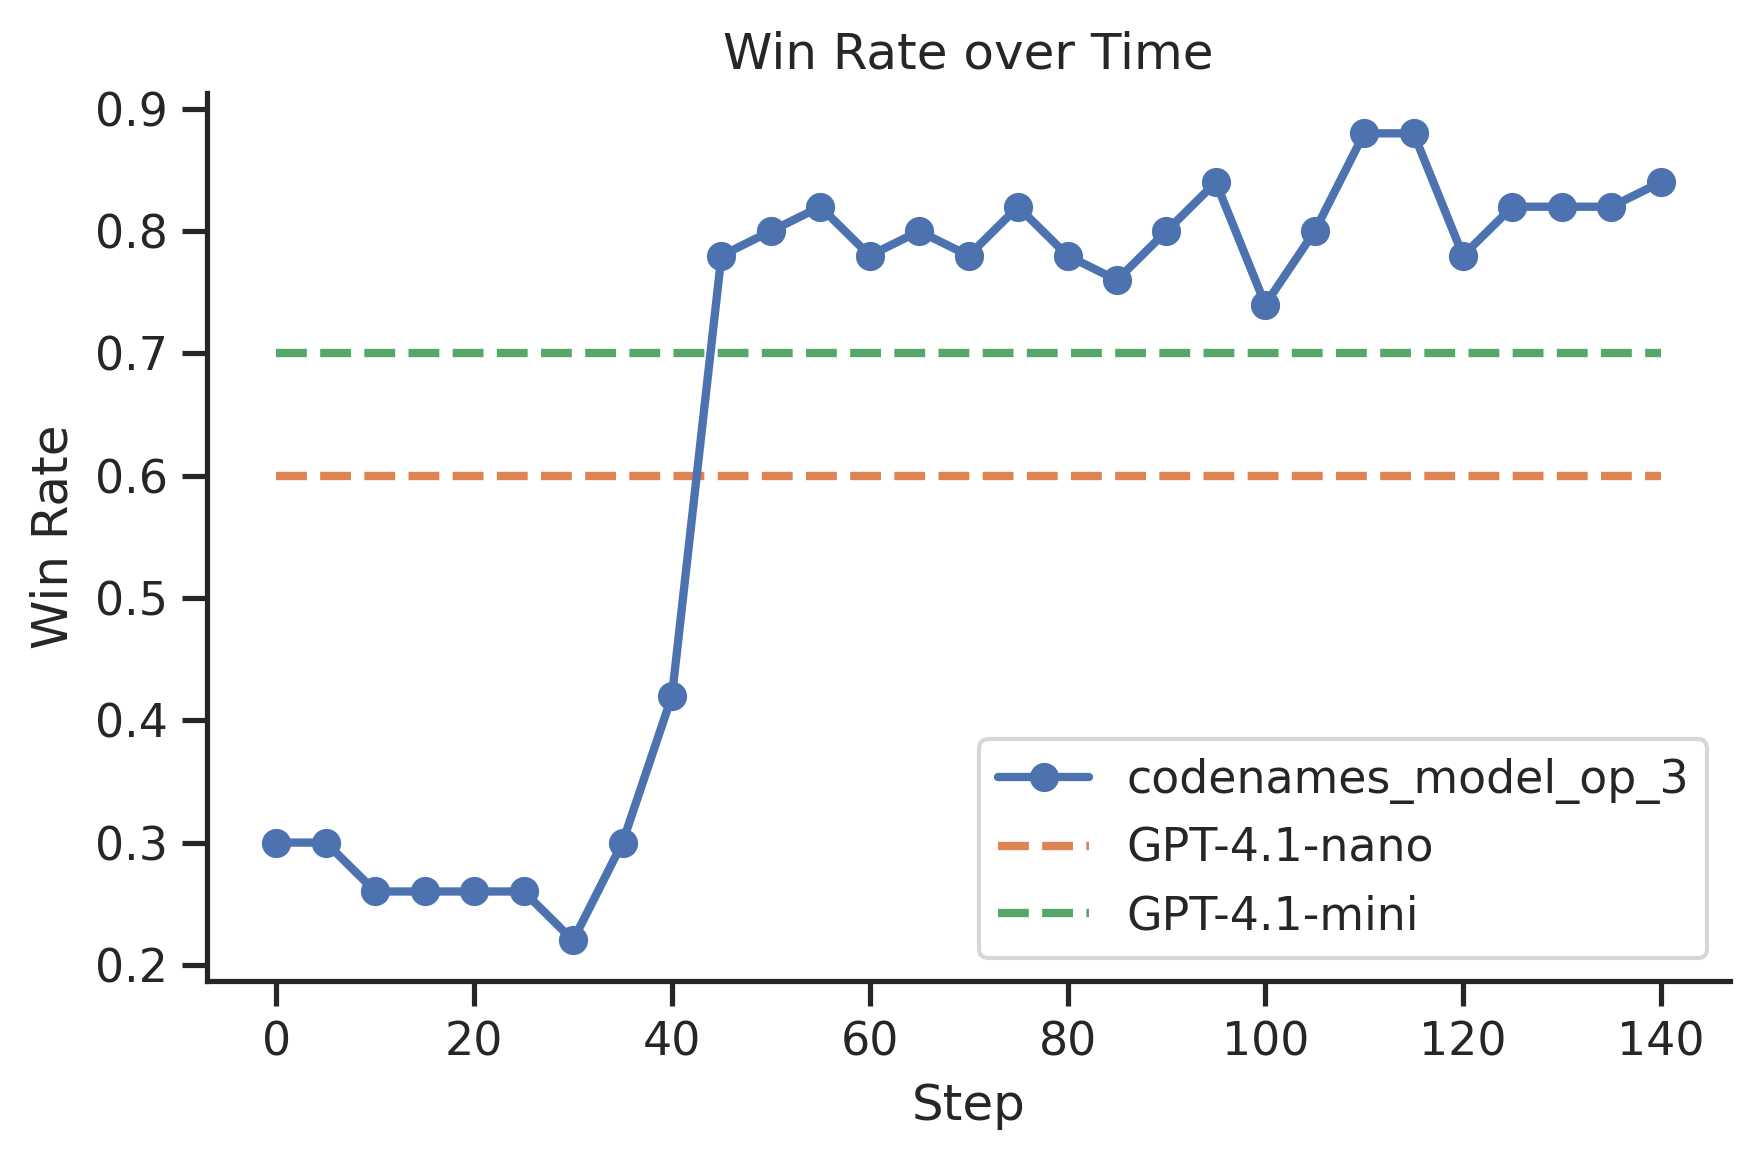

In [ ]:
# ───────────────────────────  11. Plotting Win Rate over Time  ───────────────────────────
line_graph = training_progress_chart(
    df,
    "win_rate",
    models=[
        BenchmarkModelKey(MODEL_NAME, MODEL_NAME, "val"),
        BenchmarkModelKey("gpt-4.1-nano", "GPT-4.1-nano", "val"),
        BenchmarkModelKey("gpt-4.1-mini", "GPT-4.1-mini", "val"),
    ],
    title="Win Rate over Time",
    y_label="Win Rate",
)

line_graph.savefig("win_rate_over_time.png")

<div class="align-center">
<a href="https://github.com/openpipe/art"><img src="https://github.com/openpipe/art/raw/notebooks/assets/ART_pill.png" height="50"></a>
<a href="https://discord.com/invite/dnseNZuQ"><img src="https://github.com/openpipe/art/raw/notebooks/assets/Discord_pill.png" height="50"></a>
<a href="https://openpipe.ai/blog/art-trainer-a-new-rl-trainer-for-agents"><img src="https://github.com/openpipe/art/raw/main/assets/Launch_pill.png" height="50"></a>


Questions? Join the Discord and ask away! For feature requests or to leave a star, visit our [Github](https://github.com/openpipe/art).
</div>
